# iMet Collection 2020 Kaggle Competition
Create a model that can assign attributes to artwork from Metropolitan Meuseum of Art.

Created by: Arnav Malhotra using fastai 

I followed the general transfer learning example laid out in lesson 3 of the [fastai-v3 course](http://course.fast.ai)

The main aim of this project is to get more familar with Kaggle submissions and the `data_block` API

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = Path('data/'); path

WindowsPath('data')

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,id,attribute_ids
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782
1,0000ef13e37ef70412166725ec034a8a,2997 3231 2730 3294 3099 2017 784
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23
3,000226398d224de78b191e6db45fd94e,2997 3433 448 782
4,00029c3b0171158d63b1bbf803a7d750,3465 3322 3170 1553 781


In [5]:
df_labels = pd.read_csv(path/'labels.csv')
df_labels.shape

(3474, 2)

Todo:

Why these transforms?

In [6]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
      .add_test_folder())

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

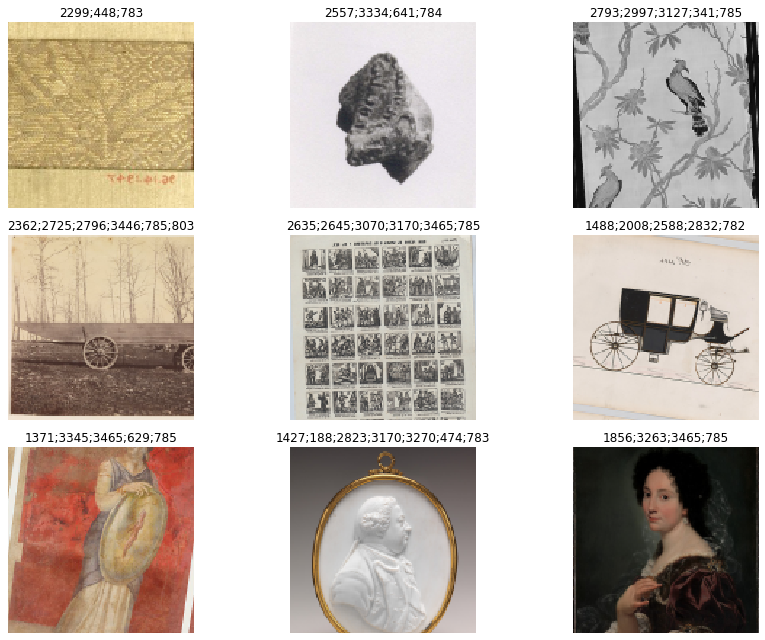

In [9]:
data.show_batch(rows=3, figsize=(12,9))

# Creating and Training Model
Using resnet50 as base architecture

In [10]:
arch = models.resnet50

In [11]:
# defining error metrics
acc_02 = partial(accuracy_thresh, thresh=0.1) # defining new metrics to report (needs to be a function)
f_score = partial(fbeta, thresh=0.1) # ''

In [12]:
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


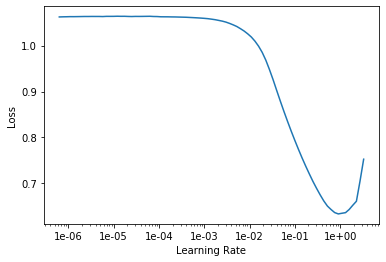

In [10]:
learn.lr_find()
learn.recorder.plot()

### Notes on choosing learning rate:

Initially I had `lr=1e-1`, and by looking at the `valid_loss`, I could tell it was too high. Check out animation in lession 2 (SGD) of the fastai course for more info on how to tell that, but essentially it was jumping all over the place. I then reduced it by half (i.e. `lr=1e-1/2` or `lr=5e-2`) since I thought that was closer to the inflection point and it was still too high. Then I reduced it to `lr=3e-2` and found that the `valid_loss` decreased slightly after the second epoch, which indicated to me that the model isn't overfitting, but then jumped really high. Let's see how it plays out, but it might be overfitting and I'll have to decrease it even more. `fbeta=0.533` at the end of first `fit_one_cycle` with that lr

During the run through, the `valid_loss` started jumping all over the place during stage-3. Additionally, during the previous stages, there were later epochs where I suspected overfitting happening, so I reduced lr to 1e-2. `fbeta=0.545` at the end of first `fit_one_cycle` with `lr=1e-2`

In [15]:
lr = 1e-2 # decrease to 1e-2 or 3e-3 next 

In [16]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.005231,0.004810,0.996436,0.449064,22:50
1,0.004707,0.004328,0.996849,0.497791,23:11
2,0.004529,0.004105,0.996564,0.512496,23:12
3,0.004357,0.003985,0.996799,0.528947,23:17
4,0.004202,0.003947,0.996858,0.532939,23:21


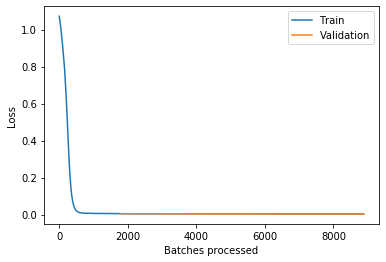

In [14]:
learn.recorder.plot_losses()

In [15]:
learn.save('stage-1-3')

## Fine-Tuning

In [16]:
learn.load('stage-1-3')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


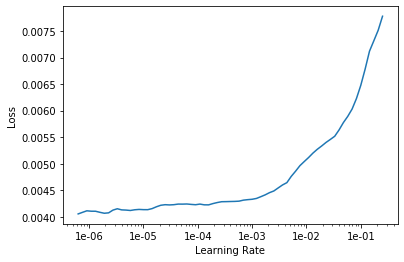

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.004238,0.003969,0.998073,0.543039,22:38
1,0.004158,0.003941,0.998262,0.548991,22:47
2,0.003989,0.003708,0.998196,0.575112,22:59
3,0.003667,0.003581,0.998244,0.590275,22:56
4,0.003602,0.003539,0.998249,0.594098,23:00


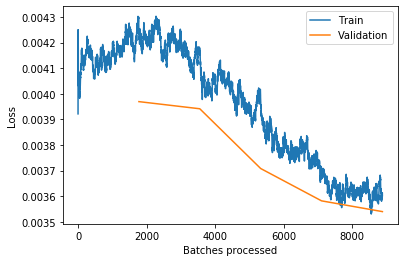

In [19]:
learn.recorder.plot_losses()

In [20]:
learn.save('stage-2-3')

# Transfer Learning

Here we use a larger image size to train again. I want to experiment with image sizes here to see what the effects are, my prediction is that I'll just have to keep reducing the batch size and it won't have too much of an effect.

Note: before this stage, fbeta in last epoch was ~0.432~ 0.594

In [13]:
learn.load('stage-2-3')
data = (src.transform(tfms, size=128*2)
       .databunch(bs=32).normalize(imagenet_stats)) # I had to decrease batch size because I ran out of memory
learn.data = data

In [14]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


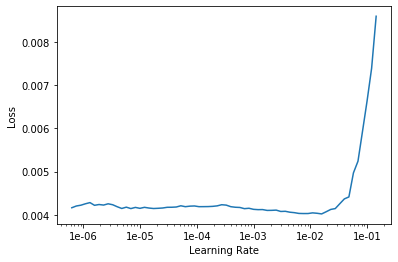

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr=1e-3

In [17]:
learn.fit_one_cycle(5, slice(lr)) #potentially change to 4 epochs

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.003869,0.003617,0.998320,0.589627,26:15
1,0.003799,0.003576,0.998185,0.593643,27:05
2,0.003868,0.003579,0.998275,0.595867,27:07
3,0.003805,0.003576,0.998305,0.597903,27:15
4,0.003780,0.003562,0.998285,0.598350,26:40


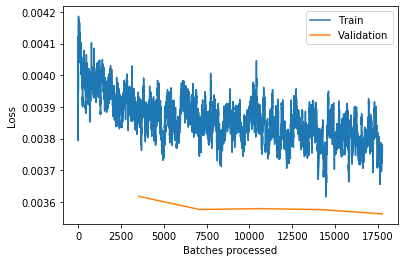

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('stage-3-4-256')
# fbeta of last epoch for img_size=256: 0.597

In [20]:
learn.load('stage-3-4-256')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


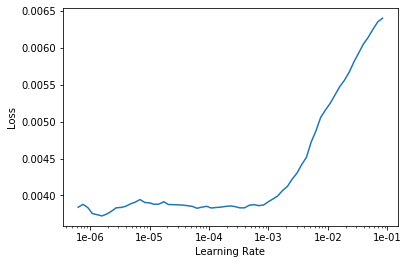

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5, slice(3e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.003849,0.003719,0.998313,0.583140,26:54
1,0.003917,0.003634,0.998192,0.589623,27:32
2,0.003830,0.003590,0.998322,0.597694,26:58
3,0.003629,0.003501,0.998319,0.608206,27:42
4,0.003704,0.003488,0.998369,0.609917,27:41


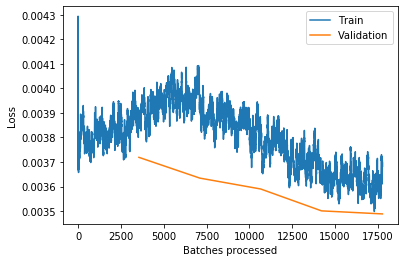

In [23]:
learn.save('stage-4-4-256')
learn.recorder.plot_losses()
#  fbeta got to 0.605

## Even More Transfer Learning

I want to explore what happens now when I train it on the entire image, but since the images are not the same size, I'll have to see how large we can make the images.

In [29]:
learn.load('stage-4-4-256')
data = (src.transform(tfms, size=400)
       .databunch(bs=16).normalize(imagenet_stats)) # I had to decrease batch size because I ran out of memory
learn.data = data

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 4.09 GiB already allocated; 0 bytes free; 279.87 MiB cached)

In [28]:
learn.lr_find()
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 4.08 GiB already allocated; 0 bytes free; 285.18 MiB cached)

In [24]:
learn.export('imet-2020.pkl')

# Creating submission file

In [4]:
test = ImageList.from_folder(path/'test')
len(test)

25958

In [5]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
len(preds)
#predictions, labels = learn.get_preds(ds_type=learn.data.test_ds)

25958

In [6]:
thresh = 0.2

fnames = [f.name[:-4] for f in learn.data.test_ds.items]

labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
print(len(fnames), len(labelled_preds))
'''pred_label = []
for pred in predictions:
    tmp = ''
    for i, p in enumerate(pred):
        if p > thresh:
            tmp = tmp + ' ' + learn.data.classes[i]
            
    pred_label.append(tmp)'''

25958 25958


"pred_label = []\nfor pred in predictions:\n    tmp = ''\n    for i, p in enumerate(pred):\n        if p > thresh:\n            tmp = tmp + ' ' + learn.data.classes[i]\n            \n    pred_label.append(tmp)"

In [7]:
df_sub = pd.DataFrame({'id': fnames, 'attribute_ids': labelled_preds},
                     columns=['id', 'attribute_ids'])
df_sub.to_csv('submission.csv', index=False)

# Fin